<a href="https://colab.research.google.com/github/Tstrebe2/predicting-text-difficulty/blob/tim-updates/notebooks/pipelines/xgboost-pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys

!{sys.executable} -m pip install -U xgboost==1.6.0 -q
!{sys.executable} -m pip install shap==0.41.0 -q

     |████████████████████████████████| 193.7 MB 25 kB/s 
     |████████████████████████████████| 569 kB 13.4 MB/s 


In [2]:
from google.colab import drive

import pandas as pd
import numpy as np
import joblib

import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, ParameterGrid

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
repo_path = '/content/drive/MyDrive/milestone-ii/'
train_path = ''.join([repo_path, 'Training_set.csv'])
test_path = ''.join([repo_path, 'Testing_set.csv'])

df_train = pd.read_csv(train_path, sep='\t', index_col='ix')
df_train['lemmatized_text'] = df_train['lemmatized_text'].fillna('')
df_test = pd.read_csv(test_path, sep='\t', index_col='ix')
df_test['lemmatized_text'] = df_test['lemmatized_text'].fillna('')

df_train.head(2)

,original_text,lemmatized_text,d_chall_score,aoa_mean,aoa_min,aoa_max,conc_rating_mean,conc_rating_min,conc_rating_max,num_lemmas,label
ix,,,,,,,,,,,
0,There is manuscript evidence that Austen conti...,there be manuscript evidence that austen conti...,8.236551,5.809310,3.57,12.12,2.495517,1.33,4.57,37.0,1
1,"In a remarkable comparative analysis , Mandaea...",in a remarkable comparative analysis mandaean ...,12.320171,7.499286,2.89,11.94,2.251429,1.46,3.77,21.0,1


In [5]:
df_test.head(2)

,original_text,lemmatized_text,d_chall_score,aoa_mean,aoa_min,aoa_max,conc_rating_mean,conc_rating_min,conc_rating_max,num_lemmas,label
ix,,,,,,,,,,,
356588,She was born with the name Maria SkÅ odowska i...,she be bear with the name maria sk odowska in ...,7.174366,4.007143,3.57,5.11,2.86,1.43,4.88,12.0,0
304697,The highest wind gust reported in Guadeloupe w...,the high wind gust report in guadeloupe be 84 ...,6.333686,5.620000,3.69,8.66,2.94,1.43,3.93,14.0,0


In [6]:
num_features = ['d_chall_score', 'aoa_max', 'num_lemmas']

text_features = 'lemmatized_text'

def build_preprocessing_pipe(tfidf_kwargs={}):

  text_pipe = Pipeline([
      ('tfidf', TfidfVectorizer(**tfidf_kwargs)),
  ])

  preprocessor = ColumnTransformer([
      ('num', 'passthrough', num_features),
      ('text', text_pipe, text_features),
  ])

  pipe = Pipeline([
      ('preprocessor', preprocessor),
  ])

  return pipe

def build_clf(tfidf_kwargs={}, clf_kwargs={}):

  text_pipe = Pipeline([
      ('tfidf', TfidfVectorizer(**tfidf_kwargs)),
  ])

  preprocessor = ColumnTransformer([
      ('num', 'passthrough', num_features),
      ('text', text_pipe, text_features),
  ])

  clf = Pipeline([
      ('preprocessor', preprocessor),
      ('clf', xgb.XGBRFClassifier(**clf_kwargs))
  ])

  return clf

In [7]:
def get_best_params_cv(df, base_params, 
                       param_grid, 
                       tfidf_params, 
                       n_splits=10, 
                       num_boost_round=500,
                       early_stopping_rounds=50,
                       verbose_eval=None):
  pipe = build_preprocessing_pipe(tfidf_params)
  skf = StratifiedKFold(n_splits=n_splits)

  best_test_scores = np.zeros(len(param_grid))
  best_train_scores = np.zeros(len(param_grid))
  best_boost_rounds = np.zeros(len(param_grid))
  
  print(f'Training started: {n_splits} splits x {len(param_grid)} param combinations = {n_splits * len(param_grid)} training epochs.')

  for i, params in enumerate(param_grid):
    print('\nparams', params)
    test_scores = np.zeros(n_splits)
    train_scores = np.zeros(n_splits)
    boost_rounds = np.zeros(n_splits)

    for n, (train_index, test_index) in enumerate(skf.split(df, df.label)):
      X_train = pipe.fit_transform(df.iloc[train_index])
      X_test = pipe.transform(df.iloc[test_index])
      y_train = df.label.iloc[train_index]
      y_test = df.label.iloc[test_index]

      dtrain = xgb.DMatrix(X_train, y_train)
      dtest = xgb.DMatrix(X_test, y_test)

      evals = [(dtest, 'test'), (dtrain, 'train')]
      evals_result = {}

      bst =  xgb.train(
          params={**params, **base_params},
          dtrain=dtrain, 
          evals=evals,
          num_boost_round=num_boost_round,
          early_stopping_rounds=early_stopping_rounds,
          evals_result=evals_result,
          verbose_eval=verbose_eval,
          )

      ix = np.argmin(evals_result['test']['logloss'])
      test_scores[n] = evals_result['test']['logloss'][ix]
      train_scores[n] = evals_result['train']['logloss'][ix]
      boost_rounds[n] = ix + 1
      print(f'fold {n+1}:',
            '\ttest loss', np.round(test_scores[n], 4), 
            'train loss', np.round(train_scores[n], 4), 
            'best_boost_round', boost_rounds[n])

    best_test_scores[i] = test_scores.mean()
    best_train_scores[i] = train_scores.mean()
    best_boost_rounds[i] = np.round(boost_rounds.mean())

  print()
  best_ix = np.argmin(best_test_scores)

  ret_val =dict(
    best_params=param_grid[best_ix],
    best_test_score=1-best_test_scores[best_ix],
    best_train_score=1-best_train_scores[best_ix],
    best_boost_rounds=int(best_boost_rounds[best_ix]),
  )

  print('Finished!')
  for key, val in ret_val.items():
    print(f'{key}:', val)

  return ret_val

In [93]:
base_params = {
              'objective': 'binary:logistic', 
              'tree_method':'gpu_hist',
              'gpu_id':0,
              'n_jobs':-1,
              'seed':99,
               }
param_grid = ParameterGrid({
              'max_depth':[18],
              'colsample_bytree':[.1, .2],
              'subsample':[.4],
              'alpha':[.8, 1],
              'eta':[5e-2]
              })

tfidf_params = {'min_df':50, 'ngram_range':(1, 3), 'max_features':500}

xgb_cv_results = get_best_params_cv(df_train.sample(40000, random_state=99, replace=False), 
                base_params, 
                param_grid, 
                tfidf_params,
                n_splits=5,
                num_boost_round=500,
                early_stopping_rounds=25,
                verbose_eval=250)

Training started: 5 splits x 4 param combinations = 20 training epochs.

params {'alpha': 0.8, 'colsample_bytree': 0.1, 'eta': 0.05, 'max_depth': 18, 'subsample': 0.4}
[0]	test-logloss:0.69021	train-logloss:0.68960
[250]	test-logloss:0.58776	train-logloss:0.48254
[499]	test-logloss:0.58768	train-logloss:0.42710
fold 1: 	test loss 0.5858 train loss 0.4535 best_boost_round 363.0
[0]	test-logloss:0.69023	train-logloss:0.68949
[250]	test-logloss:0.58730	train-logloss:0.48271
[499]	test-logloss:0.58758	train-logloss:0.42451
fold 2: 	test loss 0.5863 train loss 0.473 best_boost_round 285.0
[0]	test-logloss:0.69078	train-logloss:0.69069
[250]	test-logloss:0.58794	train-logloss:0.48095
[499]	test-logloss:0.58782	train-logloss:0.42471
fold 3: 	test loss 0.5866 train loss 0.4406 best_boost_round 409.0
[0]	test-logloss:0.68999	train-logloss:0.68926
[250]	test-logloss:0.58830	train-logloss:0.48323
[499]	test-logloss:0.58742	train-logloss:0.42390
fold 4: 	test loss 0.5861 train loss 0.4558 best_boo

Build classifier using best params

In [94]:
clf = build_clf(tfidf_params, 
                {**base_params, **xgb_cv_results['best_params'], **{'n_estimators':int(xgb_cv_results['best_boost_rounds'])}})

Final test on our training data to see if our model is overfitting.

In [95]:
X_train, X_val, y_train, y_val = train_test_split(df_train[num_features + [text_features]], 
                                                  df_train['label'],
                                                  test_size=.25,
                                                  stratify=df_train['label'], 
                                                  random_state=99)

clf = clf.fit(X_train, y_train)

train_y_proba = clf.predict_proba(X_train)[:, 1]
train_y_hat = clf.predict(X_train)

val_y_proba = clf.predict_proba(X_val)[:, 1]
val_y_hat = clf.predict(X_val)

train_roc_auc = metrics.roc_auc_score(y_train, train_y_proba)
train_accuracy = metrics.accuracy_score(y_train, train_y_hat)
train_f1 = metrics.f1_score(y_train, train_y_hat)
train_precision = metrics.precision_score(y_train, train_y_hat)
train_recall = metrics.recall_score(y_train, train_y_hat)

val_roc_auc = metrics.roc_auc_score(y_val, val_y_proba)
val_accuracy = metrics.accuracy_score(y_val, val_y_hat)
val_f1 = metrics.f1_score(y_val, val_y_hat)
val_precision = metrics.precision_score(y_val, val_y_hat)
val_recall = metrics.recall_score(y_val, val_y_hat)

print()
print('Train ROC AUC:', train_roc_auc)
print('Train Accuracy Score:', train_accuracy)
print('Train F1 Score:', train_f1)
print('Train Precision Score:', train_precision)
print('Train Recall Score:', train_recall)
print()
print('Validation ROC AUC:', val_roc_auc)
print('Validation Accuracy Score:', val_accuracy)
print('Validation F1 Score:', val_f1)
print('Validation Precision Score:', val_precision)
print('Validation Recall Score:', val_recall)


Train ROC AUC: 0.7721138256008794
Train Accuracy Score: 0.694297221303929
Train F1 Score: 0.703589326458444
Train Precision Score: 0.6828317021120024
Train Recall Score: 0.7256485543050925

Validation ROC AUC: 0.7425905063655551
Validation Accuracy Score: 0.672880253377838
Validation F1 Score: 0.6839681444010591
Validation Precision Score: 0.6615513392857143
Validation Recall Score: 0.7079574295646981


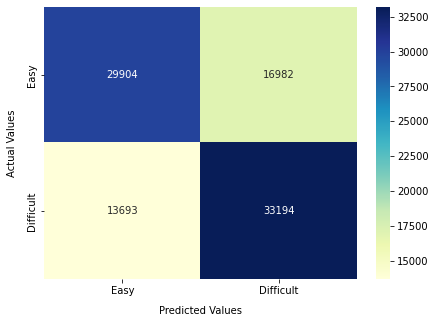

In [96]:
def plot_cf_matrix(y_true, y_pred):
  cf_matrix = metrics.confusion_matrix(y_true, y_pred).round(0)
  tick_lables = ('Easy', 'Difficult')

  fig = plt.figure(figsize=(7, 5))
  ax = plt.gca()
  ax = sns.heatmap(cf_matrix, 
              annot=True,
              fmt='.0f',
              xticklabels=tick_lables,
              yticklabels=tick_lables,
              cmap=mpl.cm.get_cmap('YlGnBu'),
              ax=ax,)
  
  ax.set_xlabel('Predicted Values', labelpad=10.0)
  ax.set_ylabel('Actual Values', labelpad=10.0)

plot_cf_matrix(y_val, val_y_hat)

Lets look at the most important features

In [97]:
text_features_trf = list(clf['preprocessor']
                         .transformers_[1][1]
                         .get_feature_names_out())

all_features = num_features + text_features_trf

ix = np.array([int(k[1:]) for k in (clf[-1]
    .get_booster()
    .get_score(importance_type='total_gain').keys())])
  
all_features = list(np.array(all_features)[ix])

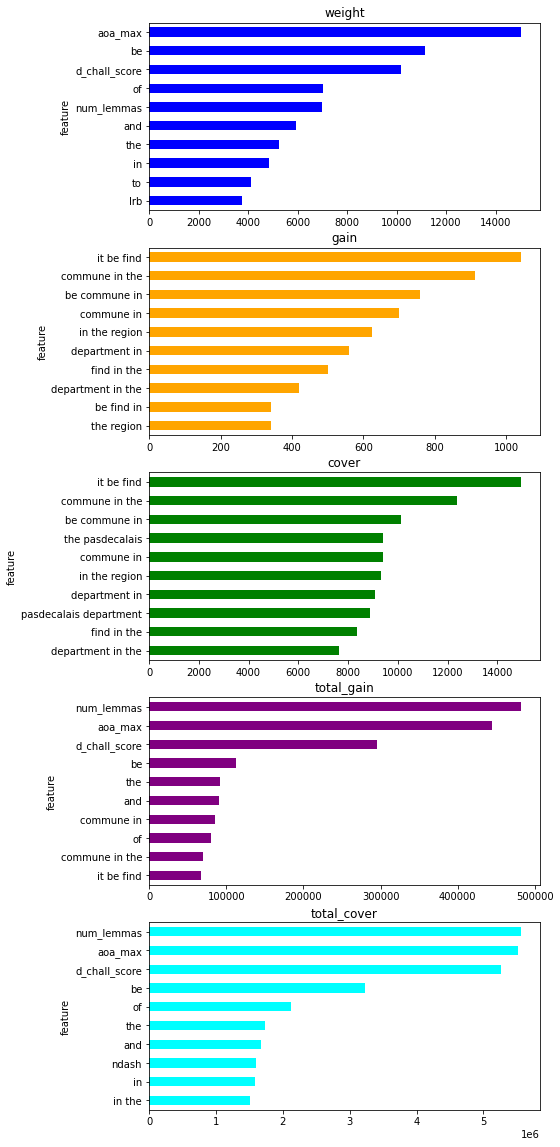

In [98]:
feature_importances = pd.DataFrame({'feature':all_features, 
                                    'weight':(clf[-1]
                                                  .get_booster()
                                                  .get_score(importance_type='weight').values()),
                                    'gain':(clf[-1]
                                                  .get_booster()
                                                  .get_score(importance_type='gain').values()),
                                    'cover':(clf[-1]
                                                  .get_booster()
                                                  .get_score(importance_type='cover').values()),
                                    'total_gain':(clf[-1]
                                                  .get_booster()
                                                  .get_score(importance_type='total_gain').values()),
                                    'total_cover':(clf[-1]
                                                  .get_booster()
                                                  .get_score(importance_type='total_cover').values()),
                                    })

# What are top 10 most important features
def plot_top_10(df_plot, ax, importance_type='gain', color='cyan'):
  df_plot = (df_plot
    .sort_values(importance_type, ascending=False)
    .head(10)
    .sort_values(importance_type))
  df_plot.plot.barh('feature', importance_type, ax=ax, legend=False, color=color)

  ax.set_title(importance_type)

importance_types = feature_importances.columns[1:].tolist()

fig, axs = plt.subplots(nrows=len(importance_types), figsize=(7, 4*len(importance_types)))
colors = ('blue', 'orange', 'green', 'purple', 'cyan')
for ax, importance_type, color in zip(axs, importance_types, colors):
  plot_top_10(feature_importances, ax, importance_type, color)

## Final Test

In [99]:
clf.fit(df_train, df_train['label'])

train_y_proba = clf.predict_proba(df_train)[:, 1]
train_y_hat = clf.predict(df_train)

test_y_proba = clf.predict_proba(df_test)[:, 1]
test_y_hat = clf.predict(df_test)

train_roc_auc = metrics.roc_auc_score(df_train['label'], train_y_proba)
train_accuracy = metrics.accuracy_score(df_train['label'], train_y_hat)
train_f1 = metrics.f1_score(df_train['label'], train_y_hat)
train_precision = metrics.precision_score(df_train['label'], train_y_hat)
train_recall = metrics.recall_score(df_train['label'], train_y_hat)

test_roc_auc = metrics.roc_auc_score(df_test['label'], test_y_proba)
test_accuracy = metrics.accuracy_score(df_test['label'], test_y_hat)
test_f1 = metrics.f1_score(df_test['label'], test_y_hat)
test_precision = metrics.precision_score(df_test['label'], test_y_hat)
test_recall = metrics.recall_score(df_test['label'], test_y_hat)

print()
print('Train ROC AUC:', train_roc_auc)
print('Train Accuracy Score:', train_accuracy)
print('Train F1 Score:', train_f1)
print('Train Precision Score:', train_precision)
print('Train Recall Score:', train_recall)
print()
print('Test ROC AUC:', test_roc_auc)
print('Test Accuracy Score:', test_accuracy)
print('Test F1 Score:', test_f1)
print('Test Precision Score:', test_precision)
print('Test Recall Score:', test_recall)


Train ROC AUC: 0.7668680007194993
Train Accuracy Score: 0.6903932901794759
Train F1 Score: 0.6975148662622453
Train Precision Score: 0.6818313753647322
Train Recall Score: 0.7139368474934149

Test ROC AUC: 0.7473336395912504
Test Accuracy Score: 0.6780881082637489
Test F1 Score: 0.6863368558870289
Test Precision Score: 0.6691893863408407
Test Recall Score: 0.7043862174872828


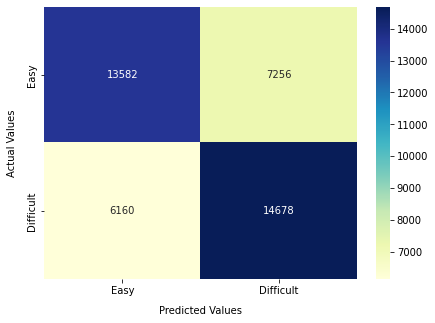

In [103]:
plot_cf_matrix(df_test['label'], test_y_hat)

In [100]:
model_path = ''.join([repo_path, 'xgboost-clf.joblib'])
joblib.dump(clf, model_path)

['/content/drive/MyDrive/milestone-ii/xgboost-clf.joblib']

In [102]:
clf = joblib.load(model_path)
print(clf)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['d_chall_score', 'aoa_max',
                                                   'num_lemmas']),
                                                 ('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_features=500,
                                                                                   min_df=50,
                                                                                   ngram_range=(1,
                                                                                                3)))]),
                                                  'lemmatized_text')])),
                ('clf',
                 XGBRFClassifier(alpha=1, base_score=0.5, booster='gbtree',
                                 callbacks=N